# Boston Housing Data Experiment 
Semi-synthetic dataset experiment


In [277]:
import sys 
sys.path.append('../..')
import cox
from cox.store import Store
from cox.utils import Parameters
from cox.readers import CollectionReader
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
import math
from delphi import oracle 
from delphi.stats.linear_regression import TruncatedRegression

# Load Boston Housing Dataset into Notebook
Load Boston Housing Dataset into notebook using SKLearn import function.

In [2]:
bunch = load_boston()
data = np.concatenate([bunch['data'], np.expand_dims(bunch['target'], 1)], axis=1)
df = pd.DataFrame(data, columns=bunch['feature_names'].tolist() + ['MEDV'])
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# Data Exploration
First, we will explore our dataset and determine which features that we can to include for our multiple linear regression problem.

When first exploring the features of our dataset, we compare the the mean the and the median values of the features from our dataset. We can see that for the ZN, TAX, CRIM, and B features that our mean and median features have both skewed distributions and more outliers.

Now, we examine the box plots of these features. When looking at the box plots, we can see that 

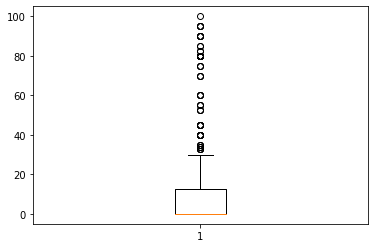

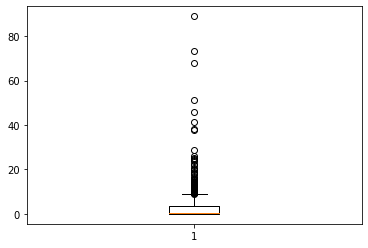

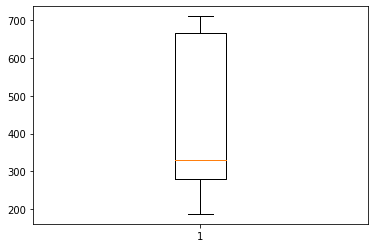

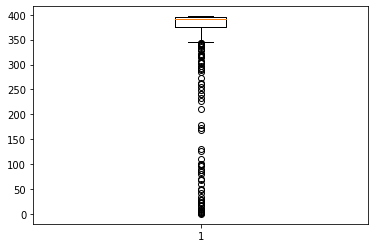

In [3]:
plt.boxplot(df['ZN'])
plt.show()
plt.boxplot(df['CRIM'])
plt.show()
plt.boxplot(df['TAX'])
plt.show()
plt.boxplot(df['B'])
plt.show()

By plotting the density of the target variable MDEV, we can see that the target variable MEDV is normally distributed, with a few outliers. 

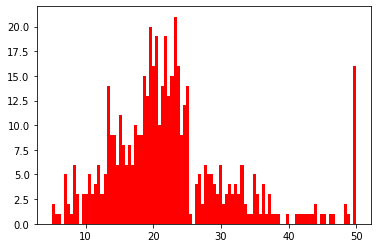

In [4]:
plt.hist(df['MEDV'], bins=100, color='red')
plt.show()

Next, by looking at the correlation matrix, we can see that the most influential features on house price are LSTAT and RM. LSTAT has a strong negative correlation with MEDV, while RM has a strong one. Intuitively, this makes sense as RM represents the numebr of rooms in the house; houses tend to cost more if they have more rooms. Further, LSTAT represents the percentage of lower status of the population; house prices tend to reflect the financial status of the population.

In [5]:
corr_matrix = df.corr()
corr_matrix

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


Look at the Correlation Between LSTAT and MEDV. We notice that although there is a strong correlation between LSTAT and MEDV, we can see that the relationship is non-linear.

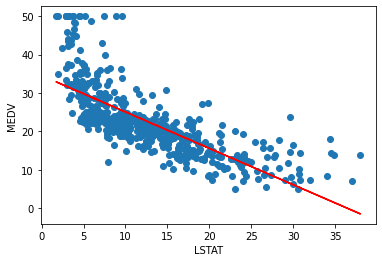

In [6]:
lstat, medv = np.expand_dims(df['LSTAT'].to_numpy(), 1), np.expand_dims(df['MEDV'].to_numpy(), 1)

# fit onls to entire "our of the box" data
ols = LinearRegression() 
ols.fit(lstat, medv)

ax = plt.subplot(1, 1, 1)
plt.scatter(df['LSTAT'], df['MEDV'])
plt.plot(lstat, ols.predict(lstat), color='red')
ax.set_xlabel('LSTAT')
ax.set_ylabel('MEDV')
plt.show()

Now, we will normalize the features in our dataset by divicing each feature by the bound of the l-infinity norm of data time $\sqrt{k}$, where $k$ is the number of dimensions that we are dealing with.

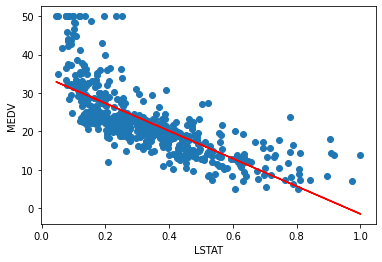

In [7]:
lstat_max_norm = LA.norm(Tensor(lstat), dim=-1, ord=float('inf')).max()
lstat_norm = lstat / lstat_max_norm

ols_ = LinearRegression()
ols_.fit(lstat_norm, medv)

ax = plt.subplot(1, 1, 1)
plt.scatter(lstat_norm, df['MEDV'])
plt.plot(lstat_norm, ols_.predict(lstat_norm), color='red')
ax.set_xlabel('LSTAT')
ax.set_ylabel('MEDV')
plt.show()

After looking at the scatter plot, we see that there is a negative correlation the percentage of the population that is lower class and the average price of the house in the area. Intuitively, this makes sense. Nowe, let's see what our ols fit looks like. 

Now, let's see how our ols fits with respect to the linear regression latent variable model. I will do this by adding Gaussian noise to what we consider to be the ground-truth regression. 

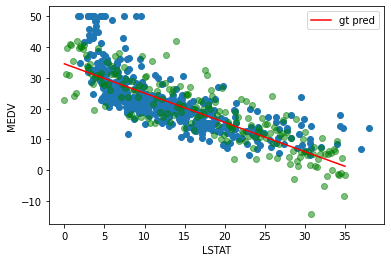

In [8]:
# create data for predicting regression values
data = np.linspace(0, 35, 200).reshape(200, 1)
gt_pred = ols.predict(data)

# calculate empirical noise std
gt_var = (medv - ols.predict(lstat)).var(0)

ax = plt.subplot(1, 1, 1)
plt.scatter(lstat, medv)
plt.plot(data, gt_pred, color='red', label='gt pred')

plt.scatter(data, gt_pred + np.sqrt(gt_var)*np.random.randn(data.shape[0], 1), color='green', alpha=.5)
ax.set_xlabel('LSTAT')
ax.set_ylabel('MEDV')
plt.legend()
plt.show()

# Truncate Normal Dataset

Now, let's see what happens when we truncate our dataset at 25.

percentage of remaining samples:  0.9525691866874695
R2 Score:  0.4905525275260083


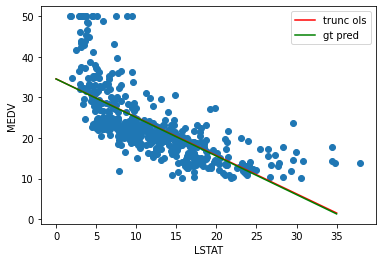

In [236]:
phi = oracle.Left(Tensor([10.0]))
# truncate data set
filtered = phi(Tensor(medv))
indices = filtered.flatten().nonzero(as_tuple=False).flatten()
x_trunc, y_trunc = lstat[indices], medv[indices]

alpha = Tensor([x_trunc.shape[0] / lstat.shape[0]])
print("percentage of remaining samples: ", float(alpha))

# create training and validation datasets
val = int(.8*len(x_trunc))

# trunc ols
trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
r2_score = trunc_ols.score(x_trunc, y_trunc)
print("R2 Score: ", r2_score)

data = np.linspace(0, 35, 200).reshape(-1, 1)
trunc_ols_pred = trunc_ols.predict(data)
ax = plt.subplot(1, 1, 1)
plt.scatter(x_trunc, y_trunc)
plt.plot(data, trunc_ols_pred, color='red', label='trunc ols')
plt.plot(data, ols.predict(data), color='green', label='gt pred')
ax.set_xlabel('LSTAT')
ax.set_ylabel('MEDV')
plt.legend()
plt.show()

Now, we scale the dependent variable of our dataset by dividing it by the underlying standard deviation of our noise variance.

In [10]:
# experiment hyperparameters
args = Parameters({ 
    'workers': 2, 
    'bs': 100,
    'bias': True,
    'num_samples': 100,
    'tol': 5e-2,
    'steps': 2000,
})
print("args: ", args)

args:  {
  "workers": 2,
  "bs": 100,
  "bias": true,
  "num_samples": 100,
  "tol": 0.05,
  "steps": 2000
}


First we will try to debias a truncated regression in the case where we assume that we know the noise variance.

/home/gridsan/stefanou/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:202: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return Variable._execution_engine.run_backward(


Iteration: 0.0 | Score: [0.03396223112940788]
Iteration: 1.0 | Score: [0.04638388380408287]


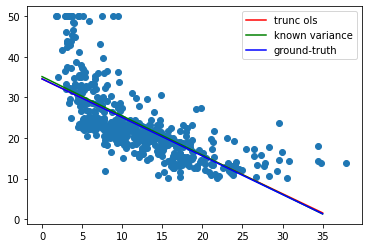

In [11]:
# scale dependent variable by std dev of noise var
noise_var = Tensor((medv - ols.predict(lstat)).var(0))
stand_y_trunc = (y_trunc / ch.sqrt(noise_var)).float()

# normalize independent variables
beta = LA.norm(Tensor(x_trunc), dim=-1, ord=float('inf')).max()
x_trunc_norm = (x_trunc / beta).float()

stand_phi = oracle.Right(Tensor([50.0]) / ch.sqrt(noise_var))
# truncated linear regression with known noise variance using empirical noise variance
known_trunc_reg = TruncatedRegression(phi=stand_phi, alpha=alpha, bias=args.bias, unknown=False, val=val, tol=args.tol, steps=args.steps, n=100)
known_results = known_trunc_reg.fit(x_trunc_norm, stand_y_trunc)
w_, w0_ = (known_results.weight.detach().cpu() * ch.sqrt(noise_var)) / beta, known_results.bias.detach().cpu() * ch.sqrt(noise_var)


# plot linear regressions
plt.plot(data, trunc_ols.predict(data), color='red', label='trunc ols')
plt.plot(data, Tensor(data)@w_ + w0_, color='green', label='known variance')
plt.plot(data, ols.predict(data), color='blue', label='ground-truth')
plt.scatter(x_trunc, y_trunc)
plt.legend()
plt.show()

Now, we will run the same procedure with unknown variance.

Iteration: 0.0 | Score: [0.0596415176987648, -0.3865806460380554]
Iteration: 1.0 | Score: [-0.05675274878740311, 0.25667494535446167]
Iteration: 2.0 | Score: [-0.12266421318054199, 0.49952930212020874]
Iteration: 3.0 | Score: [-0.11999757587909698, 0.45578306913375854]
Iteration: 4.0 | Score: [-0.14252488315105438, 0.5240346193313599]
Iteration: 5.0 | Score: [-0.1542661339044571, 0.5547561049461365]
Iteration: 6.0 | Score: [-0.14740785956382751, 0.5362746715545654]
Iteration: 7.0 | Score: [-0.15397728979587555, 0.5378885269165039]
Iteration: 8.0 | Score: [-0.13008080422878265, 0.4292113780975342]
Iteration: 9.0 | Score: [-0.13088904321193695, 0.4372366666793823]
Iteration: 10.0 | Score: [-0.16763673722743988, 0.5865127444267273]
Iteration: 11.0 | Score: [-0.1297597587108612, 0.4436333477497101]
Iteration: 12.0 | Score: [-0.11029703170061111, 0.3569606840610504]
Iteration: 13.0 | Score: [-0.10560423880815506, 0.32715949416160583]
Iteration: 14.0 | Score: [-0.08891769498586655, 0.2580566

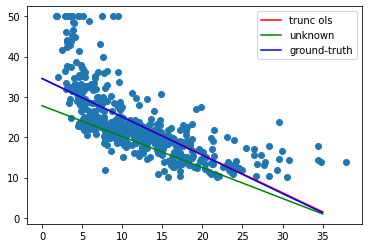

In [12]:
# scale dependent variable by std dev of noise var
emp_noise_var = Tensor((y_trunc - trunc_ols.predict(x_trunc)).var(0))
emp_stand_y_trunc = (y_trunc / ch.sqrt(emp_noise_var)).float()

# normalize independent variables
beta = LA.norm(Tensor(x_trunc), dim=-1, ord=float('inf')).max()
x_trunc_norm = (x_trunc / beta).float()

emp_stand_phi = oracle.Right(Tensor([50.0]) / ch.sqrt(emp_noise_var))
# truncated linear regression with known noise variance using empirical noise variance
unknown_trunc_reg = TruncatedRegression(phi=emp_stand_phi, alpha=alpha, bias=args.bias, unknown=True, val=val, tol=1e-1, steps=args.steps, n=100)
unknown_results = unknown_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
unknown_var = unknown_results.lambda_.inverse().detach().cpu()
w_, w0_ = (known_results.weight.detach().cpu() * ch.sqrt(emp_noise_var) * unknown_var) / beta, known_results.bias.detach().cpu() * unknown_var * ch.sqrt(emp_noise_var)


# plot linear regressions
plt.plot(data, trunc_ols.predict(data), color='red', label='trunc ols')
plt.plot(data, Tensor(data)@w_ + w0_, color='green', label='unknown')
plt.plot(data, ols.predict(data), color='blue', label='ground-truth')
plt.scatter(x_trunc, y_trunc)
plt.legend()
plt.show()

In [13]:
input_features = Tensor(df[['ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']].to_numpy())

In [19]:
rm = np.expand_dims(df['RM'].to_numpy(), 1)
rm.shape

(506, 1)

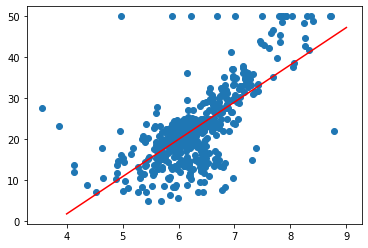

In [20]:
data = np.linspace(4, 9, 100).reshape(-1, 1)
gt = LinearRegression()
gt.fit(rm.reshape(-1, 1), medv)
plt.scatter(rm, medv)
plt.plot(data, gt.predict(data).reshape(-1, 1), color='red')

In [21]:
rm.shape

(506, 1)

noise var:  tensor([43.6869])


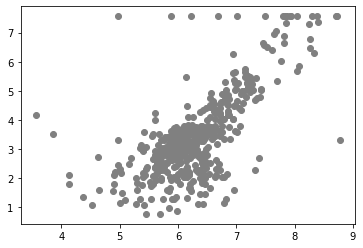

In [136]:
medv = Tensor(medv)
rm = Tensor(rm)

gt = LinearRegression()
gt.fit(rm.reshape(-1, 1), medv)

noise_var = (medv - gt.predict(rm)).var(0)
print("noise var: ", noise_var)

stand_medv = medv / ch.sqrt(noise_var)
plt.scatter(rm, stand_medv, color='grey')

alpha:  tensor([0.3617])
emp noise var:  tensor([0.8549])


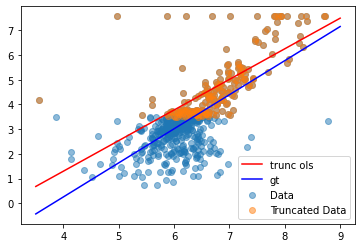

In [137]:
phi = oracle.Left(3.5)
indices = phi(stand_medv).flatten().nonzero(as_tuple=False).flatten()
x_trunc, y_trunc = rm[indices], stand_medv[indices]
alpha = Tensor([x_trunc.size(0) / rm.size(0)])
print("alpha: ", alpha)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
emp_noise_var = (y_trunc - trunc_ols.predict(x_trunc)).var(0)
print("emp noise var: ", emp_noise_var)

gt_stand = LinearRegression()
gt_stand.fit(rm, stand_medv)

data = np.linspace(3.5, 9.0, 100).reshape(-1, 1)


plt.scatter(rm, stand_medv, alpha=.5, label='Data')
plt.scatter(x_trunc, y_trunc, alpha=.5, label='Truncated Data')
plt.plot(data, trunc_ols.predict(data), label='trunc ols', color='red')
plt.plot(data, gt_stand.predict(data), label='gt', color='blue')
plt.legend()

Iteration: 0.0 | Score: [0.4421350955963135]
Iteration: 1.0 | Score: [1.5081970691680908]
Iteration: 2.0 | Score: [0.5519373416900635]
Iteration: 3.0 | Score: [0.20861628651618958]
Iteration: 4.0 | Score: [0.7648595571517944]
Iteration: 5.0 | Score: [0.41932371258735657]
Iteration: 6.0 | Score: [0.19993627071380615]
Iteration: 7.0 | Score: [0.676170289516449]
Iteration: 8.0 | Score: [0.402000367641449]
Iteration: 9.0 | Score: [0.1208379864692688]
Iteration: 10.0 | Score: [0.4768688678741455]
Iteration: 11.0 | Score: [0.3949345350265503]
Iteration: 12.0 | Score: [0.2769296169281006]
Iteration: 13.0 | Score: [0.39698973298072815]
Iteration: 14.0 | Score: [0.5222688913345337]
Iteration: 15.0 | Score: [0.4233880341053009]


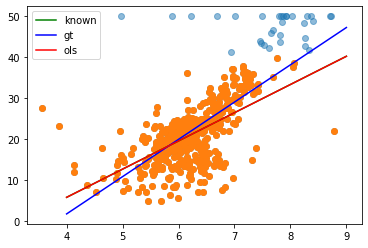

In [233]:
beta = LA.norm(rm, dim=-1, ord=float('inf')).max()
x_trunc_norm = x_trunc / beta

trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, bs=10, unknown=False, steps=1500, n=100)
trunc_reg.fit(x_trunc_norm, y_trunc)

w, w0 = (trunc_reg.weight) / beta, trunc_reg.intercept


data = np.linspace(4, 9, 100).reshape(-1, 1)
plt.scatter(rm, medv, alpha=.5)
plt.scatter(x_trunc, y_trunc)
with ch.no_grad():
    plt.plot(data, Tensor(data)@w + w0, color='green', label='known')
    plt.plot(data, gt.predict(data), color='blue', label='gt')
    plt.plot(data, trunc_ols.predict(data), color='red', label='ols')
plt.legend()

noise var:  tensor([43.6869])
alpha:  tensor([0.9387])


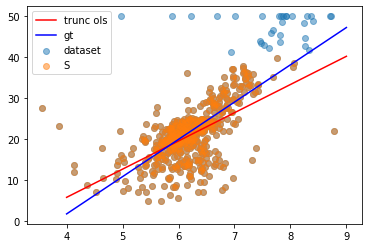

In [224]:
medv = Tensor(medv)
rm = Tensor(rm)
data = np.linspace(4, 9, 100).reshape(-1, 1)


gt = LinearRegression()
gt.fit(rm.reshape(-1, 1), medv)

noise_var = (medv - gt.predict(rm)).var(0)
print("noise var: ", noise_var)

phi = oracle.Right(40)
indices = phi(medv).flatten().nonzero(as_tuple=False).flatten()
x_trunc, y_trunc = rm[indices], medv[indices]
alpha = Tensor([x_trunc.size(0) / rm.size(0)])
print("alpha: ", alpha)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)

plt.scatter(rm, medv, label='dataset', alpha=.5)
plt.scatter(x_trunc, y_trunc, label='S', alpha=.5)
plt.plot(data, trunc_ols.predict(data), label='trunc ols', color='red')
plt.plot(data, gt.predict(data), label='gt', color='blue')
plt.legend()

Iteration: 0.0 | Score: [-0.07901372015476227]
Iteration: 1.0 | Score: [-0.2102442979812622]
Iteration: 2.0 | Score: [0.15887387096881866]
Iteration: 3.0 | Score: [-0.29882779717445374]
Iteration: 4.0 | Score: [-0.061494581401348114]


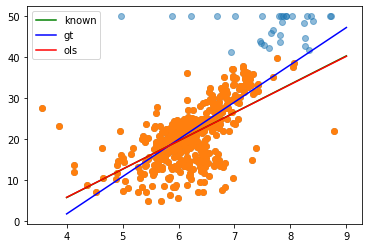

In [229]:
beta = LA.norm(rm, dim=-1, ord=float('inf')).max()
x_trunc_norm = x_trunc / beta

stand_y_trunc = y_trunc / ch.sqrt(noise_var)

phi_ = oracle.Right(phi.right / ch.sqrt(noise_var))

trunc_reg = TruncatedRegression(phi=phi_, alpha=alpha, bias=True, bs=1, unknown=False, steps=1500, n=100, val=10, tol=1e-1)
trunc_reg.fit(x_trunc_norm, stand_y_trunc)

w, w0 = (trunc_reg.weight * ch.sqrt(noise_var)) / beta, trunc_reg.intercept * ch.sqrt(noise_var)


data = np.linspace(4, 9, 100).reshape(-1, 1)
plt.scatter(rm, medv, alpha=.5)
plt.scatter(x_trunc, y_trunc)
with ch.no_grad():
    plt.plot(data, Tensor(data)@w + w0, color='green', label='known')
    plt.plot(data, gt.predict(data), color='blue', label='gt')
    plt.plot(data, trunc_ols.predict(data), color='red', label='ols')
plt.legend()

Iteration: 0.0 | Score: [0.33682021498680115, -1.2994987964630127]
Iteration: 1.0 | Score: [0.44217929244041443, -1.8374221324920654]
Iteration: 2.0 | Score: [0.5214825868606567, -2.1286673545837402]
Iteration: 3.0 | Score: [0.3231966197490692, -1.3140640258789062]
Iteration: 4.0 | Score: [0.37321802973747253, -1.5160026550292969]
Iteration: 5.0 | Score: [0.6309221982955933, -2.6557776927948]
Iteration: 6.0 | Score: [-0.16611716151237488, 0.7168328762054443]
Iteration: 7.0 | Score: [0.0005809392314404249, 0.03277301788330078]


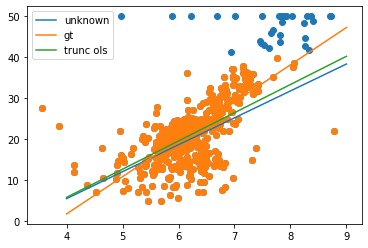

In [230]:
emp_noise_var = (y_trunc - trunc_ols.predict(x_trunc)).var(0)
emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)

beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
x_trunc_norm = x_trunc / beta

new_phi = oracle.Right(phi.right / ch.sqrt(emp_noise_var))

trunc_reg = TruncatedRegression(phi=new_phi, alpha=alpha, bias=True, bs=25, unknown=True, steps=1500, n=100, val=10, tol=1e-1)
trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)

w, w0 = (trunc_reg.weight * ch.sqrt(emp_noise_var) * trunc_reg.variance) / beta, trunc_reg.intercept * ch.sqrt(emp_noise_var) * trunc_reg.variance

plt.scatter(rm, medv)
plt.scatter(x_trunc, y_trunc)
with ch.no_grad():
    plt.plot(data, Tensor(data)@w + w0, label='unknown')
    plt.plot(data, gt.predict(data), label='gt')
    plt.plot(data, trunc_ols.predict(data), label='trunc ols')
plt.legend()

In [199]:
new_phi(emp_stand_y_trunc)

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        

In [165]:
emp_stand_y_trunc.min(), new_phi.left

(tensor(3.5143), tensor([3.4969]))

In [156]:
trunc_reg.variance * emp_noise_var

tensor([[17.8825]], grad_fn=<MulBackward0>)

Iteration: 0.0 | Score: [0.18813636898994446, -0.7030815482139587]
Iteration: 1.0 | Score: [-3.7513723373413086, 10.743545532226562]
Iteration: 2.0 | Score: [-0.048931632190942764, 0.6807776689529419]
Iteration: 3.0 | Score: [-0.9325442314147949, 4.837426662445068]
Iteration: 4.0 | Score: [0.4865550100803375, -2.2329187393188477]
Iteration: 5.0 | Score: [0.8111217617988586, -4.164723873138428]
Iteration: 6.0 | Score: [-0.5423200130462646, 3.0676872730255127]
Iteration: 7.0 | Score: [1.013371229171753, -5.49454402923584]
Iteration: 8.0 | Score: [-0.48012813925743103, 2.7556536197662354]
Iteration: 9.0 | Score: [-0.07889292389154434, 0.7258498668670654]
Iteration: 10.0 | Score: [-0.5010660886764526, 2.8443002700805664]
Iteration: 11.0 | Score: [0.2859354615211487, -1.302140235900879]
Iteration: 12.0 | Score: [0.43569737672805786, -2.191329002380371]
Iteration: 13.0 | Score: [-0.4213607907295227, 2.4278504848480225]
Iteration: 14.0 | Score: [0.38101357221603394, -1.9315611124038696]
Itera

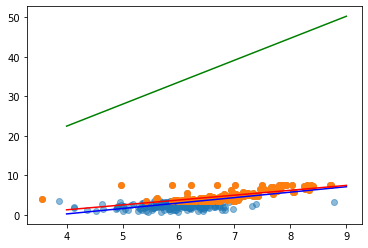

In [140]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, bs=10, unknown=True, steps=1500, n=100)
trunc_reg.fit(x_trunc_norm, y_trunc)



data = np.linspace(4, 9, 100).reshape(-1, 1)
plt.scatter(rm, stand_medv, alpha=.5)
plt.scatter(x_trunc, y_trunc)
with ch.no_grad():
    plt.plot(data, trunc_reg(Tensor(data)), color='green', label='known')
    plt.plot(data, gt_stand.predict(data), color='blue', label='gt')
    plt.plot(data, trunc_ols.predict(data), color='red', label='ols')

In [130]:
trunc_reg.bias * trunc_reg.variance

tensor([[1.0114]], grad_fn=<MulBackward0>)

In [132]:
gt_stand.intercept_

array([-5.2454886], dtype=float32)

In [ ]:
gt = LinearRegression()
gt.fit(rm.reshape(-1, 1), medv)

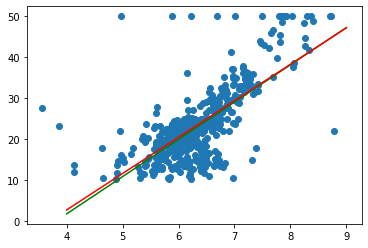

In [68]:
data = np.linspace(4, 9, 100).reshape(-1, 1)
phi = oracle.Left(10)

indices = phi(medv).flatten().nonzero(as_tuple=False).flatten()
x_trunc, y_trunc = rm[indices][...,None], medv[indices]

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)


plt.scatter(x_trunc, y_trunc)
plt.plot(data, gt.predict(data).reshape(-1, 1), color='green', label='gt')
plt.plot(data, trunc_ols.predict(data).reshape(-1, 1), color='red', label='trunc ols')

In [67]:
y_trunc.shape

torch.Size([482, 1, 1])

tensor([[ 7.0428,  9.2985],
        [12.9259,  9.0807],
        [ 5.6993, 10.1611],
        ...,
        [ 7.9762,  9.8656],
        [ 9.1641,  9.6082],
        [11.1440,  8.5277]])

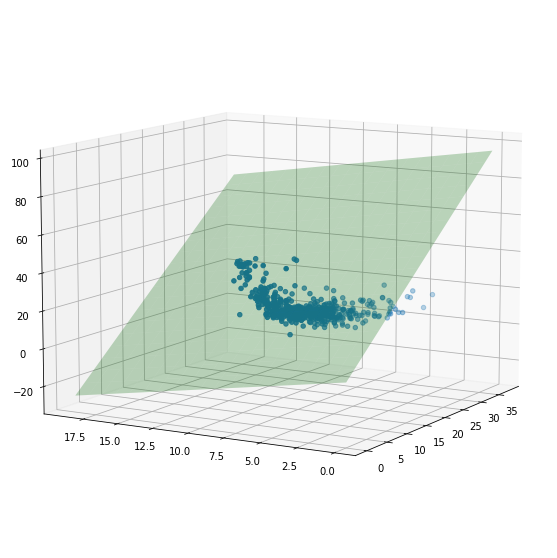

In [295]:
X = Tensor(df[['LSTAT', 'RM']].to_numpy())
beta = LA.norm(X, dim=-1, ord=float('inf'))*math.sqrt(2)

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.scatter3D(X[:,0], X[:,1], medv)

gt = LinearRegression()
gt.fit(X, medv)

x_ = np.arange(0, 40, 2)
y_ = np.arange(0, 20, 1)
x_, y_ = np.meshgrid(x_, y_)


pred = Tensor([])
for i in range(x_.shape[0]): 
    inp = Tensor(np.concatenate([np.expand_dims(x_[i], 1), np.expand_dims(y_[i], 1)], 1))
    pred = ch.cat([pred, Tensor(gt.predict(inp))], dim=1)

    
ax.plot_surface(x_, y_, pred.numpy(), color='green', alpha=.25)
ax.view_init(10, -150)

In [289]:
pred.shape

torch.Size([10, 10])

We notice that due to the magnitude of the features, our gradients became unbounded. To account for this, we will now try both standardizing and normalizing our dataset to see if this provides more stable results.

torch.Size([506, 1])

# Normalize the Data 

In [15]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
results.head()

100%|██████████| 5/5 [00:00<00:00, 239.77it/s]


,c,pred_var_mse,pred_param_mse,emp_var_mse,emp_param_mse,exp_id
0,-1.00,0.008450,0.013141,0.010971,0.026666,ce7fc4ba-f89d-4841-8845-bf0c7aaa6fc8
1,-0.75,0.041437,0.067314,0.042745,0.078930,ce7fc4ba-f89d-4841-8845-bf0c7aaa6fc8
2,-0.50,0.009972,0.030401,0.012456,0.052398,ce7fc4ba-f89d-4841-8845-bf0c7aaa6fc8
3,-0.25,0.023096,0.051561,0.024455,0.078662,ce7fc4ba-f89d-4841-8845-bf0c7aaa6fc8
4,0.00,0.032857,0.139660,0.032722,0.173678,ce7fc4ba-f89d-4841-8845-bf0c7aaa6fc8


# Plot Results

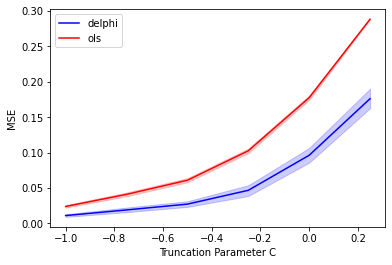

In [16]:
# plot results for regression parameter MSE
sns.lineplot(data=results, x='c', y='pred_param_mse', label='delphi', color='blue')
ax = sns.lineplot(data=results, x='c', y='emp_param_mse', label='ols', color='red')
ax.set(xlabel='Truncation Parameter C', ylabel='MSE')
plt.show()

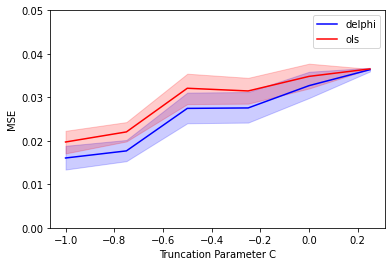

In [17]:
# plot results for regression noise variance MSE
sns.lineplot(data=results, x='c', y='pred_var_mse', label='delphi', color="blue")
ax = sns.lineplot(data=results, x='c', y='emp_var_mse', label='ols', color="red")
ax.set(xlabel='Truncation Parameter C', ylabel='MSE')
ax.set(ylim=(0, .05))
plt.show()